
#### ----------------------------------------------------*`Natural Language Processing - NLP`*--------------------------------------------------
Fake news spreads quickly on social media and can cause confusion and harm, especially in the Arabic-speaking world where tools for detection are still developing. In this project, we built a machine learning model to classify Arabic news articles as real or fake. We used Natural Language Processing (NLP) techniques to clean and prepare the text data, then extracted features and trained different models. The `XGBoost` classifier achieved the best performance with `95%` accuracy, showing strong potential for detecting fake news in Arabic and supporting efforts to reduce misinformation.

**`This Notebook Done By :`**
- **Salma Shaheen**

- **Rasha Abu Rkab**

##### ================================*`Ok , Let’s get started !`*=================================


## **1. ▶ Setup and Data Loading**

#### 1.1 Install and import the maine libraries

In [ ]:
!pip install nltk
!pip install camel_tools
!pip install farasapy
!pip install Arabic-Stopwords
!pip install utils
!pip install gensim
!pip install  emoji
!pip install num2words
!from google.colab import drive
!pip install googletrans==4.0.0-rc1
!pip install arabic_reshaper
!pip install python-bidi
!pip install wordcloud arabic-reshaper python-bidi

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
from wordcloud import WordCloud
import arabic_reshaper
import numpy as np
import nltk
import re
import emoji
import nltk
import arabicstopwords.arabicstopwords as stp
from num2words import num2words
from camel_tools.utils import dediac as camel_utils_dediac
from camel_tools.utils import normalize as camel_utils_normalize
from camel_tools.tokenizers import word as camel_utils_tokenizer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.disambig.mle import MLEDisambiguator
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import torch
import warnings
from transformers import AutoTokenizer, AutoModel
import torch
from googletrans import Translator
from farasa.stemmer import FarasaStemmer
warnings.simplefilter('ignore')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

#### 1.2 Data Loading

In [ ]:
# Read the data and show first rows
real_fake_news = pd.read_csv('/content/drive/MyDrive/merged_cleaned.csv')
real_fake_news.head()

,Id,date,platform,title,News content,Label
0,1,2023-01-11 00:00:00,Aljazeera,الضفة الغربية.. الاحتلال يهدم 17 منزلا تاريخيا...,هدمت قوات الاحتلال الإسرائيلي -اليوم الأربعاء-...,real
1,2,2023-01-11 00:00:00,Aljazeera,مظاهرات بمدن أوروبية تضامنا مع غزة وحشود أمام ...,خرجت مظاهرات في عدد من المدن الأوروبية مساء ال...,real
2,3,2023-01-11 00:00:00,Aljazeera,شهداء في جنين وطولكرم وإضراب عام بالضفة الغربي...,استشهد 4 فلسطينيين واعتقل عشرات آخرون -اليوم ا...,real
3,4,2023-02-11 00:00:00,Aljazeera,أبو عبيدة: خسائر العدو أكبر بكثير مما يعلن وسن...,أكد الناطق باسمكتائب الشهيد عز الدين القسام-ال...,real
4,5,2023-03-11 00:00:00,Aljazeera,9 شهداء بالضفة والاحتلال يشن حملة اعتقالات,استشهد 9 فلسطينيين في مواجهات اندلعت مع قوات ا...,real


## **`2. ▶ EDA - Exploratory Data Analysis `**
- Dataset shape and column types

- Missing values check

- Class distribution (real vs. fake)

- News count per platform

- Monthly news trends

- Word count distribution

- Word cloud visualization

#### **2.1 Data Info**

In [ ]:
'''
Show dataset structure:
columns
types
non-null counts
'''
real_fake_news.info()

# Check number of duplicate rows
duplicate_count = real_fake_news.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5352 non-null   int64 
 1   date          5352 non-null   object
 2   platform      5352 non-null   object
 3   title         5352 non-null   object
 4   News content  5352 non-null   object
 5   Label         5352 non-null   object
dtypes: int64(1), object(5)
memory usage: 251.0+ KB
Number of duplicate rows: 0


- **date column** should converted to datetime format
- No missing values
- No repeated rows


In [ ]:
# Convert date to datetime
real_fake_news['date'] = pd.to_datetime(real_fake_news['date']).dt.normalize()

In [ ]:
# Show the count of news articles per platform
real_fake_news['platform'].value_counts()

,count
platform,
Aljazeera,3422
Misbar,1426
Tibyan,247
X,64
الناشط حمزة المصري,37
قناة النصيرات الإخبارية,37
Facebook,17
AFP,15
الاتحاد الفلسطيني لكرة القدم,15


### **2.2 Cleaning and Standardizing Platform Names**
1. Remove invalid or unwanted platform entries : `'1'`, `'معبر كيسوفيم يستقبل 300 شاحنة'`

2. Replace variations of platform names with a standard name : `'AFP Fact Check' -> 'AFP'`, `'X'-> 'Twitter'`

3.  Reset the `id Column`



In [ ]:
# Remove unwanted platform values and make a copy
real_fake_news = real_fake_news[~real_fake_news['platform'].isin(['1', 'معبر كيسوفيم يستقبل 300 شاحنة'])].copy()

# Standardize similar platform names
real_fake_news['platform'] = real_fake_news['platform'].replace('Reuters Fact Check', 'Reuters')

real_fake_news['platform'] = real_fake_news['platform'].replace({
    'AFP Fact Check': 'AFP',
    'X': 'Twitter'
})

In [ ]:
# Replace the 'Id' column with a new sequence

real_fake_news.reset_index(drop=True, inplace=True)
real_fake_news['Id'] = range(1, len(real_fake_news) + 1)

### **2.3 News Label Distribution**
To see how many real and fake news articles are in the dataset.

- Green bars show the Numbers and percentages of real news
-  Red bars show the Numbers and percentages of fake news.


/tmp/ipython-input-11-3355755727.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=real_fake_news, x='Label', palette=palette, edgecolor='black')


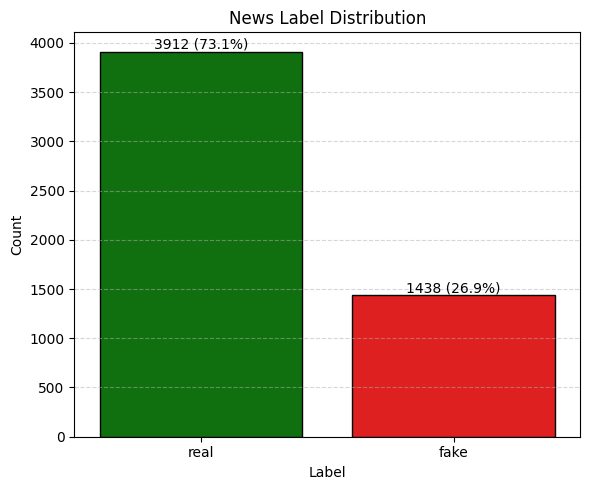

In [ ]:
# Plot label counts
palette = {'real': 'green', 'fake': 'red'}
total = len(real_fake_news)
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=real_fake_news, x='Label', palette=palette, edgecolor='black')

# Show count and percent on bars
for p in ax.patches:
    count = int(p.get_height())
    percent = f"{100 * count / total:.1f}%"
    ax.annotate(f'{count} ({percent})',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# Titles and grid
plt.title("News Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


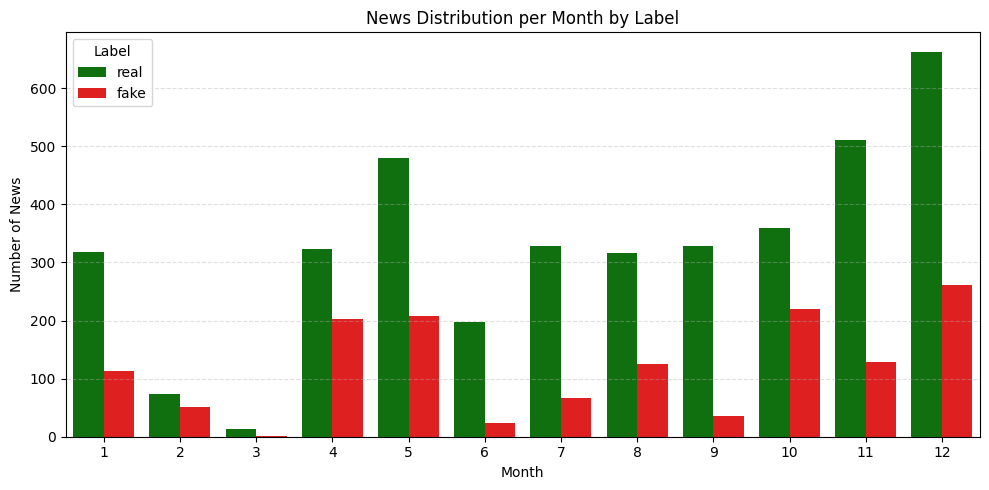

In [ ]:
# Plot count of real and fake news by month
plt.figure(figsize=(10, 5))
sns.countplot(data=real_fake_news, x=real_fake_news['date'].dt.month, hue='Label', palette={'real': 'green', 'fake': 'red'})
plt.title("News Distribution per Month by Label")
plt.xlabel("Month")
plt.ylabel("Number of News")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### **2.4 Plotting the `Real news trend` vs `Fake news trend`:**
- To see how real news changes each month

- To show the overall trend clearly

- To compare real news with fake news trends

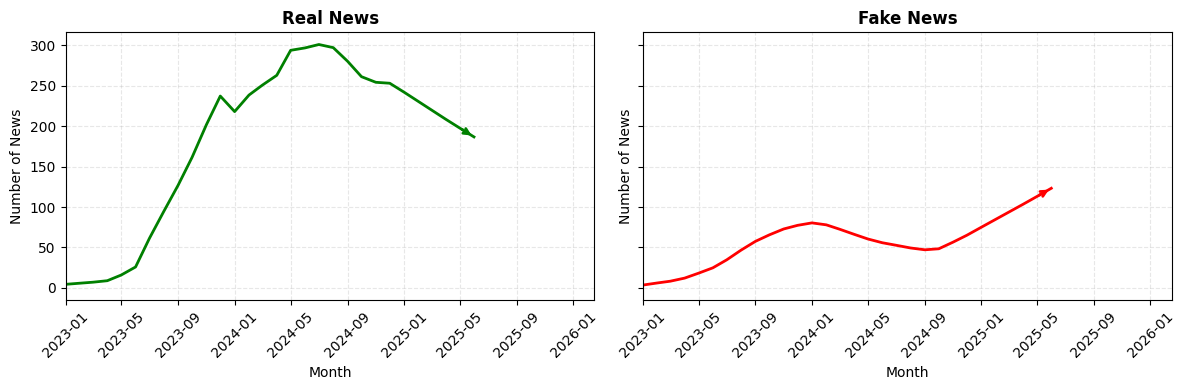

In [ ]:
# extract month period
real_fake_news['date'] = pd.to_datetime(real_fake_news['date'], errors='coerce')
real_fake_news['month'] = real_fake_news['date'].dt.to_period('M')

# Group by month then count news items
monthly_counts = real_fake_news.groupby(['month', 'Label']).size().unstack().fillna(0)
monthly_counts.index = monthly_counts.index.to_timestamp()

# Apply LOWESS smoothing
lowess_real = lowess(monthly_counts['real'], monthly_counts.index.values, frac=0.3)
lowess_fake = lowess(monthly_counts['fake'], monthly_counts.index.values, frac=0.3)

start_date = pd.Timestamp('2023-01-01')

def plot_with_arrow(x, y, color, label, ax):
    ax.plot(pd.to_datetime(x), y, color=color, linewidth=2, label=label)
    ax.annotate('', xy=(pd.to_datetime(x[-1]), y[-1]),
                xytext=(pd.to_datetime(x[-2]), y[-2]),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of News')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim(left=start_date)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot real news trend
plot_with_arrow(lowess_real[:,0], lowess_real[:,1], 'green', 'Real News', axes[0])
# Plot fake news trend
plot_with_arrow(lowess_fake[:,0], lowess_fake[:,1], 'red', 'Fake News', axes[1])

plt.tight_layout()
plt.show()


 ### **2.5 Create a visually appealing word cloud**
  that shows the most common words in the cleaned Arabic news text, shaped like a specific image `(a map of Palestine)`. **This helps to quickly see important words and themes in the dataset.**

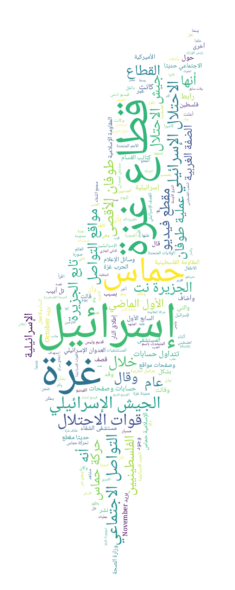

'# Generate word clouds for fake and real news\nshow_wordcloud(df[df.label == 0]["clean_text_no_stopwords"], "Fake News Word Cloud")\nshow_wordcloud(df[df.label == 1]["clean_text_no_stopwords"], "Real News Word Cloud")'

In [ ]:
# Load cleaned text (without stopwords)
df = pd.read_csv("/content/clean_news_v1.csv", encoding='windows-1256')
text = ' '.join(df['clean_text_no_stopwords'].dropna().astype(str))

reshaped_text = arabic_reshaper.reshape(text)

# Load image mask (Palestine map)
cloud_mask = np.array(Image.open("/content/drive/MyDrive/palestine.png"))

# Create a word cloud using the mask and custom settings
wordcloud = WordCloud(
    font_path='/content/drive/MyDrive/NotoNaskhArabic-Regular.ttf',
    background_color='white',
    width=800,
    height=600,
    max_words=300,
    mask=cloud_mask,
    contour_color='white',
    contour_width=1,
    colormap='viridis',
    scale=2
).generate(reshaped_text)

# Show the word cloud image without axes
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


### **2.6 Visualize the distribution of news articles across different platforms using a pie chart**
It shows how many articles come from each platform and displays the percentage share of each platform in the legend.

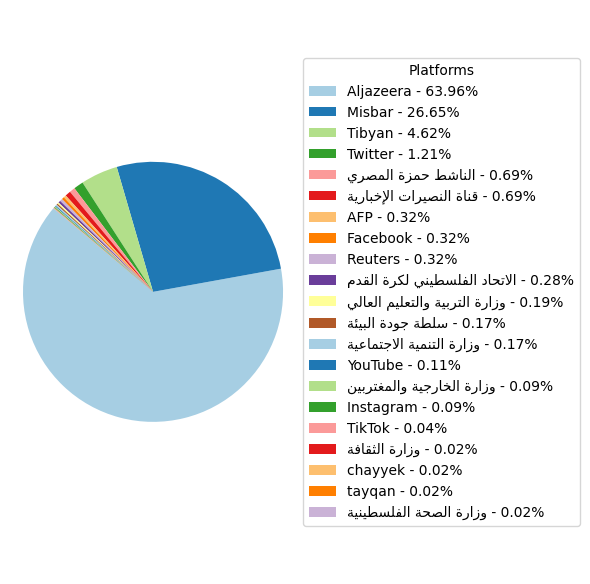

In [ ]:
# the number of news articles for each platform
platform_counts = real_fake_news['platform'].value_counts()
labels_ar = [get_display(arabic_reshaper.reshape(label)) for label in platform_counts.index]

#  percentage values
total = platform_counts.sum()
labels_with_pct = [f"{label} - {count/total*100:.2f}%" for label, count in zip(labels_ar, platform_counts)]

# Plot a pie chart
plt.figure(figsize=(6,6))
wedges, texts = plt.pie(
    platform_counts,
    labels=None,
    autopct=None,
    startangle=140,
    colors=plt.cm.Paired.colors
)

plt.legend(wedges, labels_with_pct, title="Platforms", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()


### **2.7 Histogram of Word Count in News Articles**

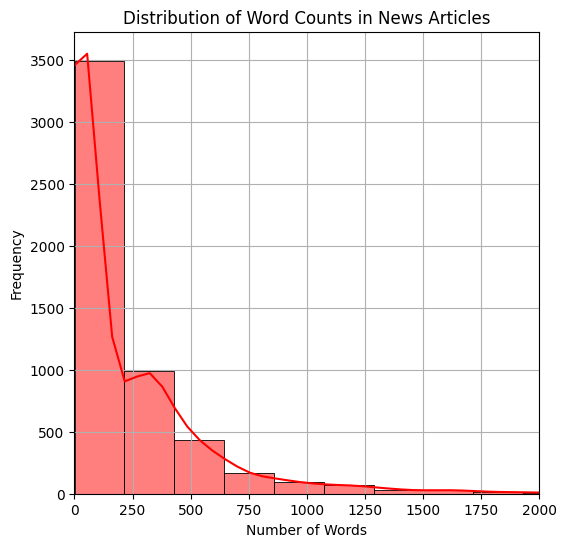

In [ ]:
real_fake_news['word_count'] = real_fake_news['News content'].apply(lambda x: len(str(x).split()))

# Plot a histogram to show the distribution of word counts
plt.figure(figsize=(6, 6))
sns.histplot(data=real_fake_news, x='word_count', bins=50, kde=True, color="red")
plt.title("Distribution of Word Counts in News Articles")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()


##**`3. ▶ Data Processing :`**

1. Reassigned IDs after cleaning.
2. Removing Diacritization (التشكيل) and punctuation.
3. Replacing links, numbers , dates and mentions with (“رقم”،“تاريخ”، “رابط”،”بريد”) .
4. Converting emojis to equivalent text. (😂 -> face_tearing_with_joy)
5. Normalizing letters. أ إ آ -> ا
6. Lemmatization using multiple tools (camel or farasa) .
7. Removing stopwords. (combined nltk and Arabic-Stopwords)
8. Removing duplicate rows.
9. Tokenization using camel-tools simple word tokenizer.
10. Translate English text ( emojis ) then delete others .
11. Remove numbers or convert to word representation ( date column ).


In [ ]:

# convert to word representation ( date column )
def convert_date_to_arabic(date_str):
    try:
        date = pd.to_datetime(date_str, errors='coerce')
        if pd.isna(date):
            return ""
        day = date.day
        month = date.month
        year = date.year
        day_word = num2words(day, lang='ar')

        months_ar = [
            'يناير', 'فبراير', 'مارس', 'أبريل', 'مايو', 'يونيو',
            'يوليو', 'أغسطس', 'سبتمبر', 'أكتوبر', 'نوفمبر', 'ديسمبر'
        ]
        month_word = months_ar[month - 1]
        year_word = num2words(year, lang='ar')

        return f" تاريخ نشر الخبر  {day_word} من شهر {month_word} سنة {year_word}"

    except Exception as e:
        print(f"Error converting date '{date_str}': {e}")
        return ""

# Apply at date column
real_fake_news['date'] = real_fake_news['date'].apply(convert_date_to_arabic)

real_fake_news

,Id,date,platform,title,News content,Label
0,1,تاريخ نشر الخبر أحد عشر من شهر يناير سنة ألف...,Aljazeera,الضفة الغربية.. الاحتلال يهدم 17 منزلا تاريخيا...,هدمت قوات الاحتلال الإسرائيلي -اليوم الأربعاء-...,real
1,2,تاريخ نشر الخبر أحد عشر من شهر يناير سنة ألف...,Aljazeera,مظاهرات بمدن أوروبية تضامنا مع غزة وحشود أمام ...,خرجت مظاهرات في عدد من المدن الأوروبية مساء ال...,real
2,3,تاريخ نشر الخبر أحد عشر من شهر يناير سنة ألف...,Aljazeera,شهداء في جنين وطولكرم وإضراب عام بالضفة الغربي...,استشهد 4 فلسطينيين واعتقل عشرات آخرون -اليوم ا...,real
3,4,تاريخ نشر الخبر أحد عشر من شهر فبراير سنة أل...,Aljazeera,أبو عبيدة: خسائر العدو أكبر بكثير مما يعلن وسن...,أكد الناطق باسمكتائب الشهيد عز الدين القسام-ال...,real
4,5,تاريخ نشر الخبر أحد عشر من شهر مارس سنة ألفا...,Aljazeera,9 شهداء بالضفة والاحتلال يشن حملة اعتقالات,استشهد 9 فلسطينيين في مواجهات اندلعت مع قوات ا...,real
...,...,...,...,...,...,...
5345,5346,تاريخ نشر الخبر ثلاثون من شهر مايو سنة ألفان...,Aljazeera,"الحرب على غزة مباشر.. مجازر إسرائيلية بمراكز ""...",في اليوم الـ77 من استئناف حرب الإبادة على غزة،...,real
5346,5347,تاريخ نشر الخبر ثلاثون من شهر مايو سنة ألفان...,Misbar,الصورة ليست لجندي مغربي سقط في كمين للمقاومة ا...,تتداول حسابات على موقع التواصل الاجتماعي إكس، ...,fake
5347,5348,تاريخ نشر الخبر ثلاثون من شهر مايو سنة ألفان...,Aljazeera,مظاهرات بإسرائيل تطالب بإكمال الصفقة وجدل حول ...,تظاهر محتجون وسط تل أبيب ليل الاثنين وأضرموا ا...,real
5348,5349,تاريخ نشر الخبر ثلاثون من شهر مايو سنة ألفان...,Aljazeera,"زكريا الزبيدي حرا.. ""التنين"" الفلسطيني الذي هز...",لم يكن في مخيلة وزير الأمن القومي الإسرائيلي ا...,real


In [ ]:

# Check if Farasa is available
FARASA_AVAILABLE = True
except ImportError:
    FARASA_AVAILABLE = False

# Create a Preprocess class to apply preprocessing steps to data
class Preprocess:
    # Load Arabic stopwords from NLTK and another library
    nltk_arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
    arabicstopwords = set(stp.stopwords_list())

    def __init__(self, EMOJIS='text', HASH_FREQ=2, BERT=False, use_farasa=True, use_camel=False):
        # Set configuration options
        print("BERT Mode:", BERT)
        print("Emoji handling mode:", EMOJIS)
        print("Using Farasa:", use_farasa and FARASA_AVAILABLE)
        print("Using Camel Tools:", use_camel)

        self.EMOJIS = EMOJIS
        self.HASH_FREQ = HASH_FREQ
        self.BERT = BERT
        self.use_farasa = use_farasa and FARASA_AVAILABLE
        self.use_camel = use_camel
        self.STOPWORDS = self.arabicstopwords.union(['', ' '])
        self.emoji_translation_cache = {}

        # Initialize Farasa stemmer
        if self.use_farasa:
            self.farasa_stm = FarasaStemmer(interactive=True)
        else:
            self.farasa_stm = None

        # Initialize Camel Tools
        if self.use_camel:
            self.db = MorphologyDB.builtin_db()
            self.analyzer = Analyzer(self.db)
            self.mle = MLEDisambiguator.pretrained()

        # Google Translator for emoji translation
        self.translator = Translator()

    # Remove diacritics from Arabic text
    def dediac(self, text):
        return camel_utils_dediac.dediac_ar(text)

    # Clean text from links, numbers, emails, and non-Arabic chars
    def tokens(self, text):
        text = re.sub(r'\b\d{1,4}[-/\.]\d{1,2}[-/\.]\d{1,4}\b', 'تاريخ', text)
        text = re.sub(r'(https?://\S+|www\.\S+)', ' رابط ', text)
        text = re.sub(r'\S*@\S*', ' بريد ', text)
        text = re.sub(r'\d+', ' رقم ', text)
        text = re.sub(r'[^\u0600-\u06FF\s_]', '', text)
        return text

    # Convert emojis to Arabic words using Google Translate
    def convert_emojis_to_meaning(self, text):
        if not isinstance(text, str):
            return text
        if self.EMOJIS == 'text':
            text = emoji.demojize(text, delimiters=(" <", "> "))
            emoji_names = set(re.findall(r'<(.*?)>', text))
            for eng_name in emoji_names:
                if eng_name in self.emoji_translation_cache:
                    ar_translation = self.emoji_translation_cache[eng_name]
                else:
                    try:
                        ar_translation = self.translator.translate(eng_name.replace('_', ' '), src='en', dest='ar').text
                        ar_translation = "ملصق_" + ar_translation.replace(' ', '_')
                        self.emoji_translation_cache[eng_name] = ar_translation
                    except Exception as e:
                        print(f"Translation failed for '{eng_name}': {e}")
                        continue
                text = text.replace(f"<{eng_name}>", ar_translation)
            return text
        elif self.EMOJIS == 'none':
            return emoji.replace_emoji(text, replace='')
        else:
            return emoji.replace_emoji(text, replace=lambda c: f' {c} ')

    # Remove punctuation and keep special tokens/hashtags
    def remove_punctuation(self, text):
        punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ«»⁉'''
        hashtags = re.findall(r'#\S+', text)
        text = re.sub(r'#\S+', '', text)
        tokens = re.findall(r'\b\w+_\w+\b', text)
        text = re.sub(r'\b\w+_\w+\b', '', text)
        text = text.translate(str.maketrans(punc, ' ' * len(punc)))
        return text + ' ' + ' '.join(tokens) + ' ' + ' '.join(hashtags)

    # Normalize Arabic letters like Alef, Teh Marbuta, etc.
    def normalize(self, text):
        text = camel_utils_normalize.normalize_alef_ar(text)
        text = camel_utils_normalize.normalize_teh_marbuta_ar(text)
        text = camel_utils_normalize.normalize_alef_maksura_ar(text)
        return text.lower()

    # Tokenize text and repeat hashtags based on frequency
    def tokenizer(self, text):
        entities = re.findall(r'\b[\w_]+\b', text)
        hashtags = re.findall(r'#(\S+)', text)
        text = re.sub(r'#\S+', '', text)

        words = []
        for token in entities:
            words.append(token)

        for tag in hashtags:
            words.extend([tag] * self.HASH_FREQ)

        return words

    # Apply Farasa stemmer
    def farasa_lemmatize(self, text):
        if not self.use_farasa:
            return []
        ret = self.farasa_stm.stem(text)
        ret_tokens = self.tokenizer(ret)
        return ret_tokens

    # Apply CamelTools lemmatizer
    def camel_lemmatize(self, text):
        tokens = camel_utils_tokenizer.simple_word_tokenize(text)
        disambig = self.mle.disambiguate(tokens)
        lemmas = [camel_utils_dediac.dediac_ar(d.analyses[0][1]['lex']) for d in disambig]
        return lemmas

    # Remove Arabic stopwords
    def remove_stopwords(self, tokenized_text):
        return [tk for tk in tokenized_text if self.dediac(tk) not in self.STOPWORDS]

    # Remove duplicate tokens
    def deduplicate(self, tokens):
        seen = set()
        deduped = []
        for tok in tokens:
            if tok not in seen:
                deduped.append(tok)
                seen.add(tok)
        return deduped

    # Remove unwanted or meaningless tokens
    def clean_tokens(self, tokens):
        return [t for t in tokens if t and not all(ch in "_-–—" for ch in t)]

    # Merge tokens separated by underscores
    def merge_underscore_tokens(self, tokens):
        merged = []
        i = 0
        while i < len(tokens):
            if tokens[i] != '_':
                current = tokens[i]
                i += 1
                while i + 1 < len(tokens) and tokens[i] == '_' and tokens[i+1] != '_':
                    current += '_' + tokens[i+1]
                    i += 2
                merged.append(current)
            else:
                i += 1
        return merged

    # Apply all preprocessing steps
    def do_all(self, text, debug=False):
        text = self.dediac(text)
        text = self.tokens(text)
        text = self.convert_emojis_to_meaning(text)
        text = self.remove_punctuation(text)
        text = self.normalize(text)

        if self.use_camel:
            tokens = self.camel_lemmatize(text)
        else:
            tokens = self.farasa_lemmatize(text)

        tokens = self.merge_underscore_tokens(tokens)
        tokens = self.remove_stopwords(tokens)
        tokens = self.deduplicate(tokens)
        tokens = self.clean_tokens(tokens)

        return tokens

    # Return cleaned tokens as a final text string
    def get_clean_string(self, text, debug=False):
        tokens = self.do_all(text, debug=debug)
        return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Make inctance from Prep Class
preprocessor = Preprocess(EMOJIS='text', use_farasa=False, use_camel=True)

# To apply at each
def preprocess(row):
    full_text = f"{row['date']} {row['title']} {row['News content']}"
    return preprocessor.get_clean_string(full_text)

real_fake_news['clean_text'] = real_fake_news.apply(preprocess, axis=1)

# Show the first result
print(real_fake_news['clean_text'].iloc[0])

BERT Mode: False
Emoji handling mode: text
Using Farasa: False
Using Camel Tools: True
تاريخ نشر خبر أحد عشرة يناير سنة فان ثلاث عشرون ضفة ٱحتلال هدم رقم منزل تاريخي مسيرة ندد عدوان غزة قوة إسرائيلي يوم أربعاء قرب بيت لحم ٱنطلق حاشد تنديد قطاعغزهفي منطقة متفرق منالضفه جانب حذر واشنطون أمة متحد ٱعتداء مستوطن مستمر فلسطيني قال حسن بريج مدير مكتب هيئة مقاومة جدار ٱستيطان مدينة جيش قرية شوشحله أشار مشيد حجر قديم عمر زاد عام لفت رفقة مستغل ٱنشغال حرب دائرة قطاع وشوشحله صغير وقع جمع غوستاف عتصيون ٱستيطاني قدس خليل سكن عدد عائلة غالبية تم تهجير ماضي عدة محتل رام الله نابلس أريحا طولكرم رفض إسناد دعم تغطية صحفي لغز شبكة إخباري بريد ٱندلع مواجهة عنيف تل كفر قدوم قلقيلية أطلق رصاص قنبلة صوت شاب إد وقوع إصابة تغطيهصحفيهجنود مركز إعلام فجر ٱقتحم بلدة جنين مقدس كبير مكون عسكري مخيم محور فرقة قناص سطح مبنى مطل داهم مواطن عبث محتوى ٱستشهد ٱعتقل عشرات آخر عملية ٱقتحام جديد نفذ إطار تصعيد إطلاق معركة طوفان أقصى شهد إضراب مجزرة غضون وصف ولاية عنف مزعزع ٱستقرار شكل حض إسرائيل ضبط ناطق ٱسم خارجي أمريكي ما

## **`4. ▶ Feature Extraction and Model Training`**

* This notebook outlines the process of feature extraction and model training for classifying palestine news  as real or fake.
* The dataset used is 'cleaned_news_v2.csv', containing preprocessed text, platform information, numerical features, and labels (fake = 0, real = 1).

#### **Objectives**

* Extract features using TF-IDF, Word2Vec (CBOW), and Word2Vec (Skip-gram).
  - We are trying to use AraBert, but it takes time and resources.

* Train and evaluate multiple machine learning models: Logistic Regression, SVM, Naive Bayes, Random Forest, and XGBoost.

* Compare model performance across different feature sets.

#### **Dataset**
* Source: cleaned_news_v2.csv
* Columns Used:
    * clean_text: Preprocessed news text.
    * platform: Source platform (e.g., الجزيرة, تويتر).
    * Numerical features: has_emoji, has_number, has_punctuation, has_hashtag, has_link, char_count, word_count.
    * Label: Target variable (fake = 0, real = 1).

#### **Adding New Features**

In [ ]:
def count_emojis(text):
    return sum(1 for c in text if emoji.is_emoji(c))

def count_numbers(text):
    return len(re.findall(r'\d', text))

def count_punctuation(text):
    return len(re.findall(r'[!()-\[\]{};:\'",<>./?@#$%^&*_~`÷×؛؟،]', text))

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def count_links(text):
    return len(re.findall(r'https?://\S+|www\.\S+', text))

def count_chars(text):
    return len(text.replace(' ', ''))

def count_words(text):
    return len(text.split())


real_fake_news['combined_text'] = real_fake_news['title'].fillna('') + ' ' + real_fake_news['News content'].fillna('')

real_fake_news['has_emoji'] = real_fake_news['combined_text'].astype(str).apply(count_emojis)
real_fake_news['has_number'] = real_fake_news['combined_text'].astype(str).apply(count_numbers)
real_fake_news['has_punctuation'] = real_fake_news['combined_text'].astype(str).apply(count_punctuation)
real_fake_news['has_hashtag'] = real_fake_news['combined_text'].astype(str).apply(count_hashtags)
real_fake_news['has_link'] = real_fake_news['combined_text'].astype(str).apply(count_links)
real_fake_news['char_count'] = real_fake_news['combined_text'].astype(str).apply(count_chars)
real_fake_news['word_count'] = real_fake_news['combined_text'].astype(str).apply(count_words)

real_fake_news.to_csv('/content/drive/MyDrive/cleaned_news_v2.csv', index=False)

#### **Data Loading**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_news_v2.csv')

# Convert platform names to Arabic
convert_eng_arb = {
    'Aljazeera': 'الجزيرة',
    'Misbar': 'مسبار',
    'Tibyan': 'تبيان',
    'Twitter': 'تويتر',
    'Reuters': 'رويترز',
    'AFP': 'فرانس برس',
    'Facebook': 'فيسبوك',
    'YouTube': 'يوتيوب',
    'Instagram': 'انستاغرام',
    'TikTok': 'تيك توك',
    'tayqan': 'تيقن',
    'chayyek': 'شييك'
}
df['platform'] = df['platform'].map(convert_eng_arb).fillna(df['platform'])

# Define numerical feature columns
num_features_cols = ['has_emoji', 'has_number', 'has_punctuation', 'has_hashtag', 'has_link', 'char_count', 'word_count']

### **2. Feature Extraction and Model Training**

##### 2.1 TF-IDF on Text Only

Extract features using TF-IDF on the clean_text column and evaluate models.

In [ ]:
texts = df['clean_text'].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = tfidf.fit_transform(texts)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
print('TF-IDF on Text Only Results')
for name, model in models.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text Only Results

----------- Logistic Regression -----------
Accuracy: 0.8822
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       288
           1       0.90      0.94      0.92       782

    accuracy                           0.88      1070
   macro avg       0.86      0.83      0.85      1070
weighted avg       0.88      0.88      0.88      1070


----------- SVM -----------
Accuracy: 0.9028
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       288
           1       0.94      0.93      0.93       782

    accuracy                           0.90      1070
   macro avg       0.87      0.88      0.88      1070
weighted avg       0.90      0.90      0.90      1070


----------- Naive Bayes -----------
Accuracy: 0.8729
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       288
           1       0.90      0.93      0.91    

##### 2.2 TF-IDF on Text and Platform

Combine TF-IDF features with one-hot encoded platform features.

In [ ]:
texts = df['clean_text'].astype(str).values
platforms = df[['platform']].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_text = tfidf.fit_transform(texts)

# One-hot encoding for platform
encoder = OneHotEncoder(sparse_output=True)
X_platform = encoder.fit_transform(platforms)

# Combine features
X = hstack([X_text, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate
print('TF-IDF on Text and Platform Results')
for name, model in models.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9411
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       300
           1       0.98      0.94      0.96       770

    accuracy                           0.94      1070
   macro avg       0.92      0.94      0.93      1070
weighted avg       0.94      0.94      0.94      1070


----------- SVM -----------
Accuracy: 0.9430
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       300
           1       0.97      0.95      0.96       770

    accuracy                           0.94      1070
   macro avg       0.93      0.94      0.93      1070
weighted avg       0.94      0.94      0.94      1070


----------- Naive Bayes -----------
Accuracy: 0.9252
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       300
           1       0.98      0.92      

##### 2.3 TF-IDF on Text, Platform, and Numerical Features

Incorporate numerical features with TF-IDF and platform features.

In [ ]:
X_num = df[num_features_cols].fillna(0).values
X_num_sparse = csr_matrix(X_num)

# Combine features
X = hstack([X_text, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate (excluding SVM) Because it takes a long time and is suitable for small data.
models_no_svm = {k: v for k, v in models.items() if k != 'SVM'}
print('TF-IDF on Text, Platform, and Numerical Features Results')
for name, model in models_no_svm.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.94      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Naive Bayes -----------
Accuracy: 0.9234
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       300
           1       0.96      0.93      0.95       770

    accuracy                           0.92      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.92      0.92      1070


----------- Random Forest -----------
Accuracy: 0.9421
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       300
        

##### 2.4 Word2Vec (CBOW) on Text Only

Use Word2Vec CBOW to generate text embeddings

In [ ]:
tokenized_texts = [word_tokenize(text) for text in texts]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, sg=0, workers=4, seed=42)

def get_avg_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_vectors = np.array([get_avg_vector(tokens, w2v_model, 100) for tokens in tokenized_texts])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vectors, labels, test_size=0.2, random_state=42, stratify=labels)

# Train and evaluate (use GaussianNB)
models_w2v = models.copy()
models_w2v['Naive Bayes'] = GaussianNB()
print('Word2Vec (CBOW) on Text Only Results')
for name, model in models_w2v.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text Only Results

----------- Logistic Regression -----------
Accuracy: 0.8327
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       288
           1       0.85      0.93      0.89       782

    accuracy                           0.83      1070
   macro avg       0.80      0.75      0.77      1070
weighted avg       0.83      0.83      0.82      1070


----------- SVM -----------
Accuracy: 0.8439
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       288
           1       0.86      0.93      0.90       782

    accuracy                           0.84      1070
   macro avg       0.82      0.77      0.79      1070
weighted avg       0.84      0.84      0.84      1070


----------- Naive Bayes -----------
Accuracy: 0.8364
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       288
           1       0.91      0.86     

##### 2.5 Word2Vec (CBOW) on Text and Platform

Combine Word2Vec embeddings with platform features.

In [ ]:
X_text_vec = np.array([get_avg_vector(doc, w2v_model, 100) for doc in tokenized_texts])
X_text_sparse = csr_matrix(X_text_vec)
X = hstack([X_text_sparse, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate (exclude MultinomialNB)
models_no_nb = {k: v for k, v in models.items() if k != 'Naive Bayes'}
print('Word2Vec (CBOW) on Text and Platform Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- SVM -----------
Accuracy: 0.9234
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       300
           1       1.00      0.89      0.94       770

    accuracy                           0.92      1070
   macro avg       0.89      0.95      0.91      1070
weighted avg       0.94      0.92      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9224
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       300
           1       0.96     

##### 2.6 Word2Vec (CBOW) on Text, Platform, and Numerical Features

Incorporate numerical features with Word2Vec and platform features.

In [ ]:
X = hstack([X_text_sparse, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }


# Train and evaluate
print('Word2Vec (CBOW) on Text, Platform, and Numerical Features Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       300
           1       0.97      0.93      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9271
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       300
           1       0.96      0.94      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9215
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       300
   

##### 2.7 Word2Vec (Skip-gram) on Text Only

Use Word2Vec Skip-gram to generate text embeddings.

In [ ]:
# Train Word2Vec Skip-gram model (sg=1 for Skip-gram)
w2v_skipgram_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, sg=1, workers=4, seed=42)

# Use same function to compute average vector
X_vectors = np.array([get_avg_vector(tokens, w2v_skipgram_model, 100) for tokens in tokenized_texts])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vectors, labels, test_size=0.2, random_state=42, stratify=labels)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }
# Train and evaluate (use GaussianNB for continuous features)
print('Word2Vec (Skip-gram) on Text Only Results')
for name, model in models_w2v.items():
    print(f'\n----------- {name}----------- ')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text Only Results

----------- Logistic Regression----------- 
Accuracy: 0.8523
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       288
           1       0.88      0.92      0.90       782

    accuracy                           0.85      1070
   macro avg       0.82      0.79      0.80      1070
weighted avg       0.85      0.85      0.85      1070


----------- SVM----------- 
Accuracy: 0.8598
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       288
           1       0.89      0.93      0.91       782

    accuracy                           0.86      1070
   macro avg       0.83      0.80      0.81      1070
weighted avg       0.86      0.86      0.86      1070


----------- Naive Bayes----------- 
Accuracy: 0.8551
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       288
           1       0.93      0.87

##### 2.8 Word2Vec (Skip-gram) on Text and Platform

Combine Word2Vec Skip-gram embeddings with platform features.

In [ ]:
X_text_vec = np.array([get_avg_vector(doc, w2v_skipgram_model, 100) for doc in tokenized_texts])
X_text_sparse = csr_matrix(X_text_vec)
X = hstack([X_text_sparse, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }

# Train and evaluate (exclude MultinomialNB)
print('Word2Vec (Skip-gram) on Text and Platform Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9299
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9271
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       300
           1       0.96      0.93      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       300
           1       

##### 2.9 Word2Vec (Skip-gram) on Text, Platform, and Numerical Features

Incorporate numerical features with Word2Vec Skip-gram and platform features.

In [ ]:
X = hstack([X_text_sparse, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }
# Train and evaluate
print('Word2Vec (Skip-gram) on Text, Platform, and Numerical Features Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9318
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.91      0.94      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9308
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       300
           1       0.97      0.94      0.95       770

    accuracy                           0.93      1070
   macro avg       0.91      0.93      0.92      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9336
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       30

##### 2.10 AraBERT with Text, Platform, and Numerical Features

Use AraBERT embeddings for text, combined with platform and numerical features.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


# Map Arabic platform names
df['platform'] = df['platform'].map(convert_eng_arb).fillna(df['platform'])

# Extract text, platform, and labels
texts = df['clean_text'].astype(str).tolist()
platforms = df[['platform']].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# Get BERT embeddings for all texts
X_text = np.array([get_bert_embedding(text) for text in texts])

# One-Hot Encoding for platform
encoder = OneHotEncoder(handle_unknown='ignore')
X_platform = encoder.fit_transform(platforms).toarray()

# Select numerical features
num_features_cols = ['has_emoji', 'has_number', 'has_punctuation', 'has_hashtag',
                     'has_link', 'char_count', 'word_count']
X_num = df[num_features_cols].fillna(0).values

# Combine all features (BERT + platform + numerical)
X = np.hstack([X_text, X_platform, X_num])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)


# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n------------- {name} -------------")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

#### its take more than 1 Hour so i save a screenshot of result

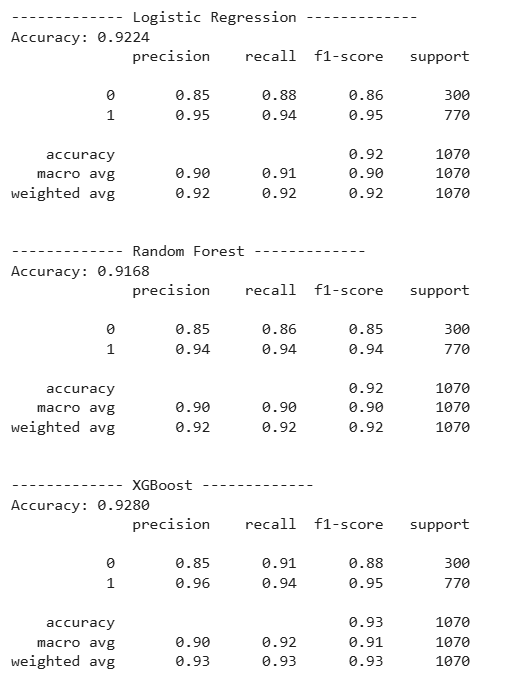

## **`5. ▶ Results Summary`**
### Performance Comparison Table
| Feature Set                              | Best Model              | Accuracy | F1-Score (Fake) | F1-Score (Real) |
|------------------------------------------|--------------------|----------|-----------------|-----------------|
| TF-IDF (Text Only)                      | XGBoost            | 92.06%   | 0.85            | 0.95            |
| TF-IDF (Text + Platform)                | XGBoost            | 95.05%   | 0.91            | 0.97            |
| TF-IDF (Text + Platform + Numerical)    | XGBoost            | 95.05%   | 0.91            | 0.97            |
| Word2Vec CBOW (Text Only)               | XGBoost            | 87.76%   | 0.77            | 0.92            |
| Word2Vec CBOW (Text + Platform)               | XGBoost, Logistic Regression            | 92.62%   | 0.88            | 0.95            |
| Word2Vec CBOW (Text + Platform + Numerical)               | Logistic Regression            | 92.62%   | 0.88            | 0.95            |
| Word2Vec Skip-gram (Text Only)          | XGBoost            | 89.16%    | 0.80           | 0.93           |
| Word2Vec Skip-gram (Text + Platform)          | Logistic Regression            | 92.99%    | 0.88           | 0.95           |
| Word2Vec Skip-gram (Text + Platform + Numerical)          | XGBoost            | 93.36%    | 0.89           | 0.95           |
| AraBERT (Text + Platform + Numerical)          | XGBoost            | 92.80%    | 0.88           | 0.95           |

## **`6.  ▶ Try to Predict the new news`**

#### **Sample 1** : The link of news  [ here ](https://www.misbar.com/factcheck/2025/05/29/%D9%81%D9%8A%D8%AF%D9%8A%D9%88-%D8%AA%D8%B2%D9%8A%D9%8A%D9%86-%D8%A7%D9%84%D9%82%D8%B5%D8%B1-%D8%A7%D9%84%D8%B1%D8%A6%D8%A7%D8%B3%D9%8A-%D9%81%D9%8A-%D8%A5%D9%86%D8%AF%D9%88%D9%86%D9%8A%D8%B3%D9%8A%D8%A7-%D8%A8%D8%B9%D9%84%D9%85-%D9%81%D9%84%D8%B3%D8%B7%D9%8A%D9%86-%D9%85%D9%88%D9%84%D9%91%D9%8E%D8%AF-%D8%A8%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A)

In [ ]:
def predict_news(text, platform, model, w2v_model, encoder, num_features_cols, convert_eng_arb):
    # Tokenize the input text
    tokenized_text = word_tokenize(text)

    # Get Word2Vec Skip-gram embedding (average vector)
    def get_avg_vector(tokens, model, vector_size):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    text_vec = get_avg_vector(tokenized_text, w2v_model, 100)
    text_vec_sparse = csr_matrix(text_vec.reshape(1, -1))

    # One-hot encode the platform
    platform = convert_eng_arb.get(platform, platform)  # Convert platform name if needed
    platform_vec = encoder.transform([[platform]])

    # Numerical features (set to 0 for simplicity, or extract actual features if available)
    num_features = np.zeros(len(num_features_cols))  # Placeholder: assumes zeros for numerical features
    num_features_sparse = csr_matrix(num_features.reshape(1, -1))

    # Combine features
    features = hstack([text_vec_sparse, platform_vec, num_features_sparse])

    # Predict
    prediction = model.predict(features)
    return 'Real' if prediction[0] == 1 else 'Fake'

# Example usage
sample_text = """
فيديو تزيين القصر الرئاسي في إندونيسيا بعلم فلسطين مولَّد بالذكاء الاصطناعي
#شاهد | تزيين قصر "إستانا نيجارا" الرئاسي في إندونيسيا بعلم فلسطيني ضخم، في لفتة رمزية تعبّر عن دعم الشعب الإندونيسي للقضية الفلسطينية
"""
sample_platform = "تويتر"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Fake


#### **Sample Test 2** : The link of news  [ here ](https://www.misbar.com/factcheck/2025/03/30/%D8%A7%D9%84%D9%81%D9%8A%D8%AF%D9%8A%D9%88-%D9%84%D9%8A%D8%B3-%D9%84%D9%85%D8%B8%D8%A7%D9%87%D8%B1%D8%A9-%D9%85%D8%B9%D8%A7%D8%B1%D8%B6%D8%A9-%D9%84%D8%AA%D8%B5%D8%AF%D9%8A%D8%B1-%D8%A7%D9%84%D9%86%D9%81%D8%B7-%D8%A7%D9%84%D8%B9%D8%B1%D8%A7%D9%82%D9%8A-%D8%A5%D9%84%D9%89-%D8%A7%D9%84%D8%A3%D8%B1%D8%AF%D9%86-%D8%A8%D8%B9%D8%AF-%D8%A3%D8%B2%D9%85%D8%A9-%D9%85%D8%A8%D8%A7%D8%B1%D8%A7%D8%A9-%D9%81%D9%84%D8%B3%D8%B7%D9%8A%D9%86)

In [ ]:
sample_text = """
الفيديو  لمظاهرة معارضة لتصدير النفط العراقي إلى الأردن بعد أزمة مباراة فلسطين
الجنوب العراقي يشتعل غضباً ويزحف على الحقول النفطية، عازماً على منع تصدير النفط إلى الأردن اللوطية .
"""
sample_platform = "تويتر"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Fake


#### **Sample Test 3** :The link of news  [ here ](https://www.aljazeera.net/news/liveblog/2025/7/14/%D8%A7%D9%84%D8%AD%D8%B1%D8%A8-%D8%B9%D9%84%D9%89-%D8%BA%D8%B2%D8%A9-%D9%85%D8%A8%D8%A7%D8%B4%D8%B1-%D8%B9%D8%B4%D8%B1%D8%A7%D8%AA-%D8%A7%D9%84%D8%B4%D9%87%D8%AF%D8%A7%D8%A1-33)

In [ ]:
sample_text = """
مسؤولة إغاثة: وضع مستشفيات قطاع غزة كارثي
المتحدثة باسم الاتحاد الدولي لجمعيات الهلال والصليب الأحمر للجزيرة:

وضع مستشفيات قطاع غزة كارثي.
نقص كبير بعدد سيارات الإسعاف العاملة في غزة.
انعدام الوقود يعني غياب الحياة تماما بغزة.
انعدام الوقود بمستشفيات غزة يعني انعدام فرص الحياة.
فقدنا العديد من موظفينا بسبب القصف على غزة.
"""
sample_platform = "الجزيرة"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Real


## **`7.  ▶ Conclusion`**

* #### The XGBoost model with TF-IDF on text, platform, and numerical features achieved the highest accuracy (95.05%).
* #### This combination is recommended for deployment. Future work could explore hyperparameter tuning and advanced embeddings like AraBERT with more computational resources.

## **`8.  ▶ Future Improvements`**
- Experiment with deep learning models like LSTMs or Transformers.
- Incorporate sentiment analysis as an additional feature.
- Collect more diverse data to improve model generalization.

##### ================================*`Thank you !`*=================================
